# <center>Introduction to ML - Decision Tree Coursework</center>
### <center>COMP70050</center>

### Installing dependencies

Step 1 

In [188]:
import numpy as np

# Making our results reproducible
np.random.seed(1337)

clean_data = np.loadtxt("wifi_db/clean_dataset.txt", delimiter='\t')
noisy_data = np.loadtxt("wifi_db/noisy_dataset.txt")

In [136]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    prob = counts / np.sum(counts)
    return -np.sum(prob * np.log2(prob))

In [137]:
def find_split(dataset):
    # We split out dataset, x is the array of features and y is the labels
    x = dataset[:, :-1]
    y = dataset[:, -1]

    # n is the number of samples and k is the number of features
    n, k = x.shape

    H_total = entropy(y)

    max_gain = 0
    best_attribute = -1
    best_split = None

    for attribute in range(k):
        arr = x[:, attribute]
        uniques = np.unique(arr)

        for split in uniques:
            left_ds = y[arr <= split]
            right_ds = y[arr > split]

            remainder = ((len(left_ds)/len(arr)) * entropy(left_ds)) + ((len(right_ds)/len(arr)) * entropy(right_ds))
            
            if max_gain < H_total - remainder:

                max_gain = H_total - remainder
                best_attribute = attribute
                best_split = split
    
    return best_attribute, best_split

In [138]:
def decision_tree_learning(dataset, depth=0):
    total_instances = len(dataset)
    x = dataset[:, :-1]
    y = dataset[:, -1]
    
    if len(np.unique(y)) == 1:
        return (Node(None, y[0], None, None, total_instances, True), depth)
    else:
        attribute, value = find_split(dataset)
        l_dataset = dataset[dataset[:, attribute] <= value]
        r_dataset = dataset[dataset[:, attribute]  > value]
        l_node, l_depth = decision_tree_learning(l_dataset, depth + 1)
        r_node, r_depth = decision_tree_learning(r_dataset, depth + 1)
        node = Node(attribute, value, l_node, r_node, total_instances, False)
        return (node, max(l_depth, r_depth))

In [139]:
class Node:
    def __init__(self, attribute, value, left, right, n_instances: int, is_leaf: bool):
        self.attribute = attribute
        self.value = value
        self.left = left
        self.right = right
        self.n_instances = n_instances
        self.is_leaf = is_leaf


In [140]:
def predict(node, X):
    if node.is_leaf:
        return np.full(len(X), node.value)
    
    left_indices = X[:, node.attribute] <= node.value
    right_indices = X[:, node.attribute] > node.value
    
    predictions  = np.zeros(len(X))
    predictions[left_indices] = predict(node.left, X[left_indices])
    predictions[right_indices] = predict(node.right, X[right_indices])

    return predictions  

### Step 3 : Evaluation

In [141]:
# Function taken from Lab 3
def confusion_matrix(y_gold, y_prediction, class_labels=None):
    
    # if no class_labels are given, we obtain the set of unique class labels from
    # the union of the ground truth annotation and the prediction
    if not class_labels:
        class_labels = np.unique(np.concatenate((y_gold, y_prediction)))

    confusion = np.zeros((len(class_labels), len(class_labels)))

    # for each correct class (row),
    # compute how many instances are predicted for each class (columns)
    for i, correct_class in enumerate(class_labels):
        for j, predicted_class in enumerate(class_labels):
            count = np.count_nonzero(np.logical_and(y_gold == correct_class, y_prediction == predicted_class))
            confusion[i][j] = count

    return confusion

def accuracy(confusion):
    return np.trace(confusion) / np.sum(confusion) if np.sum(confusion) > 0 else 0


def precision(confusion):

    # Compute the precision per class
    p = np.diag(confusion) / np.sum(confusion, axis=1)

    # Compute the macro-averaged precision
    macro_p = np.mean(p)

    return (p, macro_p)

def recall(confusion):

    # Compute the recall per class
    r = np.diag(confusion) / np.sum(confusion, axis=0)
    # Compute the macro-averaged recall
    macro_r = np.mean(r)
    return (r, macro_r)

def f1_score(confusion):


    (precisions, macro_p) = precision(confusion)
    (recalls, macro_r) = recall(confusion)

    # just to make sure they are of the same length
    assert len(precisions) == len(recalls)

    f = (2*precisions*recalls) / (precisions + recalls)

    macro_f = np.mean(f)

    return (f, macro_f)

In [184]:
def train_test_k_fold(n_folds, n_instances, random_generator=np.random.default_rng()):

    shuffled_indices = random_generator.permutation(n_instances)
    split_indices = np.array_split(shuffled_indices, n_folds)

    folds = []
    for k in range(n_folds):
        test_indices = split_indices[k]
        train_indices = np.concatenate(split_indices[:k] + split_indices[k+1:])

        folds.append([train_indices, test_indices])

    return folds

In [189]:
import matplotlib.pyplot as plt

n_folds = 10
dataset = noisy_data

confusion_matrices = np.zeros((n_folds, 4, 4))
accuracies = np.zeros(n_folds)
macro_precisions = np.zeros((n_folds))
per_class_precisions = np.zeros((n_folds, 4))
macro_recalls = np.zeros((n_folds))
per_class_recalls = np.zeros((n_folds, 4))
macro_f1_scores = np.zeros((n_folds))
per_class_f1_scores = np.zeros((n_folds, 4))

for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(dataset))):
    x_test = dataset[test_indices, :-1]
    y_test = dataset[test_indices, -1]
    
    tree, depth = decision_tree_learning(dataset[train_indices, :])
    y_pred = predict(tree, x_test)
    
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)
    accuracies[i] = accuracy(confusion_matrices[i])
    per_class_precisions[i] = precision(confusion_matrices[i])[0]
    macro_precisions[i] = precision(confusion_matrices[i])[1]
    per_class_recalls[i] = recall(confusion_matrices[i])[0]
    macro_recalls[i] = recall(confusion_matrices[i])[1]
    per_class_f1_scores[i] = f1_score(confusion_matrices[i])[0]
    macro_f1_scores[i] = f1_score(confusion_matrices[i])[1]

In [190]:
accuracies

array([0.795, 0.775, 0.74 , 0.82 , 0.83 , 0.775, 0.795, 0.755, 0.805,
       0.82 ])

In [191]:
print("--- Accuracies ---")
print("- Mean accuracy : ", np.mean(accuracies))
print("- Accuracy Amplitude : ", np.max(accuracies) - np.min(accuracies))

print("--- Precisions ---")
print("- Mean precision : ", np.mean(macro_precisions))
print("- Precision Amplitude : ", np.max(macro_precisions) - np.min(macro_precisions))
print("- Room 1 mean precision : ", np.mean(per_class_precisions[0]))
print("- Room 2 mean precision : ", np.mean(per_class_precisions[1]))
print("- Room 3 mean precision : ", np.mean(per_class_precisions[2]))
print("- Room 4 mean precision : ", np.mean(per_class_precisions[3]))

print("--- Recalls ---")
print("- Mean recalls : ", np.mean(macro_recalls))
print("- Recall Amplitude : ", np.max(macro_recalls) - np.min(macro_recalls))
print("- Room 1 mean recall : ", np.mean(per_class_recalls[0]))
print("- Room 2 mean recall : ", np.mean(per_class_recalls[1]))
print("- Room 3 mean recall : ", np.mean(per_class_recalls[2]))
print("- Room 4 mean recall : ", np.mean(per_class_recalls[3]))

print("--- F1-Scores ---")
print("- Mean F1-Score : ", np.mean(macro_f1_scores))
print("- F1-Score Amplitude : ", np.max(macro_f1_scores) - np.min(macro_f1_scores))
print("- Room 1 mean F1-Score : ", np.mean(per_class_f1_scores[0]))
print("- Room 2 mean F1-Score : ", np.mean(per_class_f1_scores[1]))
print("- Room 3 mean F1-Score : ", np.mean(per_class_f1_scores[2]))
print("- Room 4 mean F1-Score : ", np.mean(per_class_f1_scores[3]))

--- Accuracies ---
- Mean accuracy :  0.791
- Accuracy Amplitude :  0.08999999999999997
--- Precisions ---
- Mean precision :  0.7900131520322213
- Precision Amplitude :  0.09134022118650464
- Room 1 mean precision :  0.7911067193675889
- Room 2 mean precision :  0.7698101517975312
- Room 3 mean precision :  0.7380157636316651
- Room 4 mean precision :  0.8202564102564103
--- Recalls ---
- Mean recalls :  0.7891432838016337
- Recall Amplitude :  0.09411981923175816
- Room 1 mean recall :  0.7907700190308886
- Room 2 mean recall :  0.7669047619047619
- Room 3 mean recall :  0.7361925945501526
- Room 4 mean recall :  0.8212374581939799
--- F1-Scores ---
- Mean F1-Score :  0.7889345833063494
- F1-Score Amplitude :  0.0934918341824369
- Room 1 mean F1-Score :  0.7908986808336046
- Room 2 mean F1-Score :  0.7671586411938248
- Room 3 mean F1-Score :  0.7361382613820646
- Room 4 mean F1-Score :  0.820571387311062


/var/folders/45/d9xkv7rx7q9dpsbzfljnv0n80000gn/T/ipykernel_28185/3275756794.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


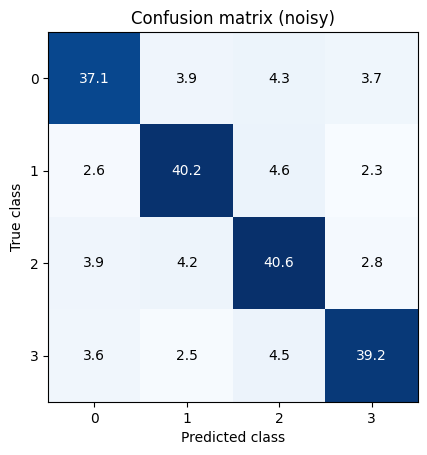

In [166]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm

def get_text_color(val, cmap_name, conf):
    # Normalisation de la valeur
    v_min, v_max = np.min(conf), np.max(conf)
    normalized_val = (val - v_min) / (v_max - v_min)
    
    # Obtention de la couleur RGB pour cette valeur
    cmap = plt.cm.get_cmap(cmap_name)
    rgb = cmap(normalized_val)[:3]  # On ignore l'alpha
    
    # Calcul de la luminance
    # Formule standard pour la luminance perçue
    luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    
    # Retourne blanc si la cellule est sombre, noir si elle est claire
    return "white" if luminance < 0.5 else "black"

def custom_colormap():
    # Définition des couleurs RGB (normalisées entre 0 et 1)
    color_1 = np.array([1, 1, 1])
    # color_1 = np.array([217/255, 226/255, 255/255])
    color_2 = np.array([0/255, 0/255, 205/255])
    
    # Création des points de contrôle
    colors = [color_1, color_2]
    
    # Création de la colormap
    n_bins = 256  # Nombre de niveaux de couleur
    cm = LinearSegmentedColormap.from_list('custom_blue', colors, N=n_bins)
    
    return cm

cmap = "Blues"


heatmap = np.mean(confusion_matrices, axis=0)
fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap=cmap)
ax.set_xticks(np.arange(4), labels=np.arange(4))
ax.set_yticks(np.arange(4), labels=np.arange(4))
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")

for i in range(4):
    for j in range(4):
        text = ax.text(j, i, heatmap[i, j],
                       ha="center", va="center", color=get_text_color(heatmap[i, j], cmap, heatmap))

ax.set_title("Confusion matrix (noisy)")
plt.savefig("confusion-matrix-noisy.png")
plt.show()

### Step 4 : Pruning

In [9]:
def evaluate(test_dataset, trained_tree):
    y_pred = predict(trained_tree, test_dataset[:, :-1])
    
    accuracy = np.mean(y_pred == test_dataset[:, -1])
    return accuracy

In [10]:
def prune_tree(node: Node, train_dataset, val_dataset):
    
    if node.is_leaf:
        return node

    left_train_dataset = train_dataset[train_dataset[:, node.attribute] <= node.value]
    right_train_dataset = train_dataset[train_dataset[:, node.attribute] > node.value]
    
    node.left = prune_tree(node.left, left_train_dataset, val_dataset)
    node.right = prune_tree(node.right, right_train_dataset, val_dataset)
    
    if node.left.is_leaf and node.right.is_leaf:

        new_value = node.left.value if node.left.n_instances > node.right.n_instances else node.right.value
        potential_leaf = Node(None, new_value, None, None, len(train_dataset), True)

        if evaluate(val_dataset, node) <= evaluate(val_dataset, potential_leaf):
            return potential_leaf

    return node


In [12]:
dataset = noisy_data
n_folds = 10
n_instances = len(dataset)

confusion_matrices = np.zeros((n_folds, 4, 4))
accuracies = np.zeros(n_folds)
precisions = np.zeros(n_folds)
recalls = np.zeros(n_folds)
f1_scores = np.zeros(n_folds)

confusion_matrices_after = np.zeros((n_folds, 4, 4))
accuracies_after = np.zeros(n_folds)
precisions_after = np.zeros(n_folds)
recalls_after = np.zeros(n_folds)
f1_scores_after = np.zeros(n_folds)

for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(x))):
    # Splitting the train and test
    x_train = dataset[train_indices, :-1] # pas utile ici
    y_train = dataset[train_indices, -1] # pas utile ici
    x_test = dataset[test_indices, :-1]
    y_test = dataset[test_indices, -1]

    root, depth = decision_tree_learning(dataset[train_indices])
    y_pred = predict(root, x_test)

    root = prune_tree(root, dataset[train_indices], dataset[test_indices])
    y_pred_after = predict(root, x_test)

    confusion_matrices[i] = confusion_matrix(np.int8(y_test), np.int8(y_pred))
    accuracies[i] = accuracy(confusion_matrices[i])
    precisions[i] = precision(confusion_matrices[i])[1]
    recalls[i] = recall(confusion_matrices[i])[1]
    f1_scores[i] = f1_score(confusion_matrices[i])[1]
    train_dataset = np.column_stack((x_test, y_test))    

    confusion_matrices_after[i] = confusion_matrix(np.int8(y_test), np.int8(y_pred_after))
    accuracies_after[i] = accuracy(confusion_matrices_after[i])
    precisions_after[i] = precision(confusion_matrices_after[i])[1]
    recalls_after[i] = recall(confusion_matrices_after[i])[1]
    f1_scores_after[i] = f1_score(confusion_matrices_after[i])[1]
    train_dataset_after = np.column_stack((x_test, y_test))  
    
print("Before pruning:")
print(f"Accuracy: {accuracies.mean():.2f}")
print(f"Precision: {precisions.mean():.2f}")
print(f"Recall: {recalls.mean():.2f}")
print(f"F1 Score: {f1_scores.mean():.2f}")

print("\nAfter pruning:")
print(f"Accuracy: {accuracies_after.mean():.2f}")
print(f"Precision: {precisions_after.mean():.2f}")
print(f"Recall: {recalls_after.mean():.2f}")
print(f"F1 Score: {f1_scores_after.mean():.2f}")


Before pruning:
Accuracy: 0.80
Precision: 0.80
Recall: 0.81
F1 Score: 0.80

After pruning:
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.82
